# INFO 3401 – Class 08: Joining and Merging data

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

## Learning Objectives
This may review content you have learned in other classes, but we want to start with the same foundation since pandas is so fundamental to everything else we will do in this class!

* Understanding differences and trade-offs between different join types
* Developing join strategy based on features of the data
* Using pandas `merge` function to combine DataFrames
* Exploratory data analysis around factors correlated with vaccine hesitancy in Colorado schools

## Background

Our goal is to perform an exploratory data analysis around the factors that contribute to [vaccine hesitancy](https://en.wikipedia.org/wiki/Vaccine_hesitancy) in Colorado, the state with the [lowest rate of childhood vaccinations in the country](https://www.cdc.gov/mmwr/volumes/67/wr/mm6740a3.htm?s_cid=mm6740a3_w) and [strong political resistance to eliminating personal exemptions](https://coloradosun.com/2019/02/21/colorado-vaccination-rate-lowest-fix-jared-polis/) to vaccination requirements.

Research question: **What are some school-level factors that explain the differences in vaccination rates in Colorado schools?**

The State of Colorado publishes a variety of data about schools throughout the state:

* Membership by grade level, free and reduced lunch, ethnicity/gender: [Pupil Membership](https://www.cde.state.co.us/cdereval/pupilcurrentschool)
* [Immunization data (2016-17)](https://www.cohealthdata.dphe.state.co.us/Data/Details/1) and [2017-2020](https://www.dcphrapps.dphe.state.co.us/Reports/ReportList/Partners) (Under Data Downloads > Download All Data)

## Load libraries

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

## Load and Inspect data

In [2]:
info_df = pd.read_csv('cleaned_school_info.csv',encoding='utf8',
                      dtype={'Low Grade':str,'High Grade':str,'District Code':str,'Sch Code':str})
print(info_df.shape)
info_df.head()

(2949, 14)


,School Year,County Name,District Code,District Name,Setting,Sch Code,School Name,Low Grade,High Grade,Elem Level,Middle Level,Senior Level,System Code,Charter
0,2021,Weld,3085,Eaton RE-2,Outlying Town,4820,Eaton Early Learning Center,004,004,True,False,False,Non-Public,False
1,2021,Weld,3085,Eaton RE-2,Outlying Town,0754,Benjamin Eaton Elementary School,030,050,True,False,False,Public,False
2,2021,Weld,3085,Eaton RE-2,Outlying Town,2456,Eaton High School,090,120,False,False,True,Public,False
3,2021,Routt,2770,Steamboat Springs RE-2,Outlying City,4812,Steamboat Springs Early Childhood Center,004,004,True,False,False,Public,False
4,2021,Saguache,2790,Mountain Valley RE 1,Remote,6146,Mountain Valley School,004,120,False,False,True,Public,False


In [3]:
shots_df = pd.read_csv('cleaned_school_vaccination.csv',encoding='utf8')
print(shots_df.shape)
shots_df.head()

(2231, 5)


,School Name,2016-17 Vacciations,2017-18 Vaccinations,2018-19 Vaccinations,2019-20 Vaccinations
0,5280 High School,NaN,NaN,NaN,0.829787
1,70 Online,0.9413,0.881081,0.906736,0.886555
2,Allies,NaN,NaN,0.904348,0.907563
3,Axis International Academy,NaN,NaN,NaN,0.730570
4,Abraham Lincoln High School,0.9271,0.925965,0.890591,0.888043


In [4]:
students_df = pd.read_csv('cleaned_school_enrollments.csv',encoding='utf8',
                          dtype={'School Code':str,'Org. Code':str})
print(students_df.shape)
students_df.head()

(7577, 14)


,Year,Org. Code,Organization Name,School Code,School Name,Native Enrollment,Asian Enrollment,Black Enrollment,Hispanic Enrollment,White Enrollment,Islander Enrollment,Multiracial Enrollment,Female Enrollment,PK-12 Total
0,2016-17,0010,MAPLETON 1,0187,Mapleton Expeditionary School Of The Arts,0.010972,0.007837,0.020376,0.710031,0.227273,0.001567,0.025078,0.492163,638
1,2016-17,0010,MAPLETON 1,0212,Mapleton Early College High School,0.008163,0.016327,0.016327,0.697959,0.224490,0.004082,0.008163,0.506122,245
2,2016-17,0010,MAPLETON 1,0263,Global Leadership Academy,0.000000,0.010050,0.005025,0.914573,0.065327,0.000000,0.000000,0.472362,199
3,2016-17,0010,MAPLETON 1,0309,Academy High School,0.018391,0.018391,0.039080,0.770115,0.121839,0.004598,0.018391,0.402299,435
4,2016-17,0010,MAPLETON 1,0501,Monterey Community School,0.000000,0.012397,0.018595,0.851240,0.109504,0.000000,0.000000,0.500000,484


## Clean up data

In [8]:
shots_df.columns = ['School Name', '2016-17', '2017-18', '2018-19', '2019-20']

shots_melted_df = pd.melt(shots_df,
                          id_vars=['School Name'],
                          var_name='Year',
                          value_name='Vaccination Rate')
print(shots_melted_df.shape)
shots_melted_df.head()

(8924, 3)


,School Name,Year,Vaccination Rate
0,5280 High School,2016-17,NaN
1,70 Online,2016-17,0.9413
2,Allies,2016-17,NaN
3,Axis International Academy,2016-17,NaN
4,Abraham Lincoln High School,2016-17,0.9271


In [7]:
shots_melted_df[shots_melted_df['School Name'] == '70 Online']

,School Name,Year,Vaccination Rate
1,70 Online,2016-17,0.941300
2232,70 Online,2017-18,0.881081
4463,70 Online,2018-19,0.906736
6694,70 Online,2019-20,0.886555


## Decide on joining strategy

Before we even attempt a join, look closely at each of these tables.

* **Variables.** What variables do they share in common that could be used as keys in a join?
* **Coverage.** Do both tables cover the same ranges of time?
* **Duplicates.** Are there instances of multiple/repeated rows of these key variables? Why is that?
* **Strategy.** What is the most appropriate merging strategy to handle the different time windows and repeated dates?
* **Shape.** What should the data look like afterwards?  
  * How many rows? 
  * How many columns? 
  * Which values should repeat? 
  * Which values should be null? 
  * Which values should disappear?
  
If you do not have answers for these questions, you are not prepared to evaluate the quality of a join and are likely to make serious errors resulting in duplicated or dropped data.

### Variables

In [9]:
info_df.head(2)

,School Year,County Name,District Code,District Name,Setting,Sch Code,School Name,Low Grade,High Grade,Elem Level,Middle Level,Senior Level,System Code,Charter
0,2021,Weld,3085,Eaton RE-2,Outlying Town,4820,Eaton Early Learning Center,004,004,True,False,False,Non-Public,False
1,2021,Weld,3085,Eaton RE-2,Outlying Town,0754,Benjamin Eaton Elementary School,030,050,True,False,False,Public,False


In [10]:
shots_melted_df.head(2)

,School Name,Year,Vaccination Rate
0,5280 High School,2016-17,NaN
1,70 Online,2016-17,0.9413


In [11]:
students_df.head(2)

,Year,Org. Code,Organization Name,School Code,School Name,Native Enrollment,Asian Enrollment,Black Enrollment,Hispanic Enrollment,White Enrollment,Islander Enrollment,Multiracial Enrollment,Female Enrollment,PK-12 Total
0,2016-17,0010,MAPLETON 1,0187,Mapleton Expeditionary School Of The Arts,0.010972,0.007837,0.020376,0.710031,0.227273,0.001567,0.025078,0.492163,638
1,2016-17,0010,MAPLETON 1,0212,Mapleton Early College High School,0.008163,0.016327,0.016327,0.697959,0.224490,0.004082,0.008163,0.506122,245


In [17]:
len(set(students_df['School Name'].unique()) & set(info_df['School Name'].unique()))

1801

In [18]:
len(set(students_df['School Code'].unique()) & set(info_df['Sch Code'].unique()))

1900

In [20]:
len(set(shots_melted_df['School Name'].unique()) & set(info_df['School Name'].unique()))

1698

In [21]:
len(set(students_df['School Name'].unique()) & set(shots_melted_df['School Name'].unique()))

1684

### Coverage

In [22]:
info_df['School Year'].value_counts()

2021                   2948
2020-09-11 00:00:00       1
Name: School Year, dtype: int64

In [23]:
shots_melted_df['Year'].value_counts()

2018-19    2231
2019-20    2231
2016-17    2231
2017-18    2231
Name: Year, dtype: int64

In [24]:
students_df['Year'].value_counts()

2019-20    1908
2018-19    1903
2017-18    1889
2016-17    1877
Name: Year, dtype: int64

### Duplicates

In [29]:
students_df['School Name'].value_counts()

4     1586
1      129
2      108
3       99
8       46
12      10
20       2
16       2
6        2
5        2
7        1
Name: School Name, dtype: int64

In [31]:
info_df['School Name'].value_counts()

Kindercare Learning Center         5
Early Childhood Center             5
Columbine Elementary School        5
Mountain View Elementary School    5
Mesa Elementary School             4
                                  ..
Elevation Ability Services         1
Florida Mesa Head Start            1
The Colorado Springs School        1
Sarah Milner Elementary School     1
Mountain Song Community School     1
Name: School Name, Length: 2839, dtype: int64

In [33]:
shots_melted_df['School Name'].value_counts()

Mountain View Elementary School               20
Columbine Elementary School                   20
Mesa Elementary School                        16
Centennial Elementary School                  16
Lincoln Elementary School                     12
                                              ..
Pleasant View Middle School                    4
Bella Romero Academy Of Applied Technology     4
Ryan Elementary School                         4
W H Heaton Middle School                       4
Fleming School K-12                            4
Name: School Name, Length: 2093, dtype: int64

In [36]:
info_df[info_df['School Name'] == 'Mesa Elementary School']

,School Year,County Name,District Code,District Name,Setting,Sch Code,School Name,Low Grade,High Grade,Elem Level,Middle Level,Senior Level,System Code,Charter
271,2021,Boulder,0480,Boulder Valley Re 2,Denver Metro,5838,Mesa Elementary School,006,050,True,False,False,Public,False
1108,2021,Montezuma,2035,Montezuma-Cortez RE-1,Outlying City,5836,Mesa Elementary School,006,050,True,False,False,Public,False
1787,2021,El Paso,1000,Fountain 8,Urban-Suburban,3108,Mesa Elementary School,006,050,True,False,False,Public,False
2117,2021,Adams,0070,Westminster Public Schools,Denver Metro,5834,Mesa Elementary School,004,050,True,False,False,Public,False


In [39]:
info_df['Sch Code'].value_counts().value_counts()

1    2949
Name: Sch Code, dtype: int64

In [41]:
students_df['School Code'].value_counts().value_counts()

4    1820
3      53
1      53
2      42
Name: School Code, dtype: int64

### Strategy

When we call `how='left'` in `pd.merge`, we make sure all the keys we're joining on that are present in the "left" DataFrame remain in the merged DataFrame. A left-join is ideal if you really trust and want to preserve all the data in your left DataFrame, even if it means losing data in your right DataFrame.

When we call `how='right'` in `pd.merge`, we make sure all the keys we're joining on that are present in the "right" DataFrame remain in the merged DataFrame. A right-join is ideal if you really trust and want to preserve all the data in your right DataFrame, even if it means losing data in your left DataFrame.

![From W3 Schools](https://www.w3schools.com/sql/img_rightjoin.gif)

![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_merge_on_key_right.png)

This all suggests a few different strategies: 

1. A **left join** would preserve all the rows in the left DataFrame but only include rows from the right DataFrame if they have a matching key. If there are keys in the left that are not present in the right, there will be null values in the right columns.
2. A **right join** would preserve all the rows in the right DataFrame but only include rows from the left DataFrame if they have a matching key. If there are keys in the right that are not present in the left, there will be null values in the left columns.
3. An **outer join** that preserves all the rows in both the left and right DataFrames. Where the keys do not match up, there will be missing data in either the left and right columns respectively. This tends to produce the largest table but with the most missing values.
4. An **inner join** will preserve all only the rows if there is a matching key from both the left and the right. This tends to produce the smallest table but also with the fewest missing values.

![From W3 Schools](https://www.w3schools.com/sql/img_leftjoin.gif)

![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_merge_on_key_left.png)

![From W3 Schools](https://www.w3schools.com/sql/img_innerjoin.gif)

![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_merge_on_key_inner.png)

![From W3 Schools](https://www.w3schools.com/sql/img_fulljoin.gif)

![](https://pandas.pydata.org/pandas-docs/stable/_images/merging_merge_on_key_outer.png)

In [42]:
info_df.shape

(2949, 14)

In [43]:
students_df.shape

(7577, 14)

In [48]:
len(set(info_df['Sch Code'].unique()) - set(students_df['School Code'].unique()))

1049

In [49]:
len(set(students_df['School Code'].unique()) - set(info_df['Sch Code'].unique()))

69

In [44]:
info_df.head(2)

,School Year,County Name,District Code,District Name,Setting,Sch Code,School Name,Low Grade,High Grade,Elem Level,Middle Level,Senior Level,System Code,Charter
0,2021,Weld,3085,Eaton RE-2,Outlying Town,4820,Eaton Early Learning Center,004,004,True,False,False,Non-Public,False
1,2021,Weld,3085,Eaton RE-2,Outlying Town,0754,Benjamin Eaton Elementary School,030,050,True,False,False,Public,False


In [45]:
students_df.head(2)

,Year,Org. Code,Organization Name,School Code,School Name,Native Enrollment,Asian Enrollment,Black Enrollment,Hispanic Enrollment,White Enrollment,Islander Enrollment,Multiracial Enrollment,Female Enrollment,PK-12 Total
0,2016-17,0010,MAPLETON 1,0187,Mapleton Expeditionary School Of The Arts,0.010972,0.007837,0.020376,0.710031,0.227273,0.001567,0.025078,0.492163,638
1,2016-17,0010,MAPLETON 1,0212,Mapleton Early College High School,0.008163,0.016327,0.016327,0.697959,0.224490,0.004082,0.008163,0.506122,245


### Shape

## Join

In [50]:
join_students_info_left_df = pd.merge(left = students_df,
                                 right = info_df,
                                 left_on = 'School Code',
                                 right_on = 'Sch Code',
                                 how = 'left'
                                )

join_students_info_right_df = pd.merge(left = students_df,
                                 right = info_df,
                                 left_on = 'School Code',
                                 right_on = 'Sch Code',
                                 how = 'right'
                                )

join_students_info_inner_df = pd.merge(left = students_df,
                                 right = info_df,
                                 left_on = 'School Code',
                                 right_on = 'Sch Code',
                                 how = 'inner'
                                )

join_students_info_outer_df = pd.merge(left = students_df,
                                 right = info_df,
                                 left_on = 'School Code',
                                 right_on = 'Sch Code',
                                 how = 'outer'
                                )

## Evaluate join

In [51]:
join_students_info_left_df.shape

(7577, 28)

In [52]:
join_students_info_right_df.shape

(8467, 28)

In [53]:
join_students_info_inner_df.shape

(7418, 28)

In [54]:
join_students_info_outer_df.shape

(8626, 28)

In [55]:
join_students_info_left_df.head()

,Year,Org. Code,Organization Name,School Code,School Name_x,Native Enrollment,Asian Enrollment,Black Enrollment,Hispanic Enrollment,White Enrollment,Islander Enrollment,Multiracial Enrollment,Female Enrollment,PK-12 Total,School Year,County Name,District Code,District Name,Setting,Sch Code,School Name_y,Low Grade,High Grade,Elem Level,Middle Level,Senior Level,System Code,Charter
0,2016-17,0010,MAPLETON 1,0187,Mapleton Expeditionary School Of The Arts,0.010972,0.007837,0.020376,0.710031,0.227273,0.001567,0.025078,0.492163,638,2021,Adams,0010,Mapleton 1,Denver Metro,0187,Mapleton Expeditionary School Of The Arts,070,120,False,False,True,Public,False
1,2016-17,0010,MAPLETON 1,0212,Mapleton Early College High School,0.008163,0.016327,0.016327,0.697959,0.224490,0.004082,0.008163,0.506122,245,2021,Adams,0010,Mapleton 1,Denver Metro,0212,Mapleton Early College High School,090,120,False,False,True,Public,False
2,2016-17,0010,MAPLETON 1,0263,Global Leadership Academy,0.000000,0.010050,0.005025,0.914573,0.065327,0.000000,0.000000,0.472362,199,2021,Adams,0010,Mapleton 1,Denver Metro,0263,Global Leadership Academy,090,120,False,False,True,Public,False
3,2016-17,0010,MAPLETON 1,0309,Academy High School,0.018391,0.018391,0.039080,0.770115,0.121839,0.004598,0.018391,0.402299,435,2021,Adams,0010,Mapleton 1,Denver Metro,0309,Academy High School,090,120,False,False,True,Public,False
4,2016-17,0010,MAPLETON 1,0501,Monterey Community School,0.000000,0.012397,0.018595,0.851240,0.109504,0.000000,0.000000,0.500000,484,2021,Adams,0010,Mapleton 1,Denver Metro,0501,Monterey Community School,006,080,True,False,False,Public,False


In [56]:
join_students_info_right_df.head()

,Year,Org. Code,Organization Name,School Code,School Name_x,Native Enrollment,Asian Enrollment,Black Enrollment,Hispanic Enrollment,White Enrollment,Islander Enrollment,Multiracial Enrollment,Female Enrollment,PK-12 Total,School Year,County Name,District Code,District Name,Setting,Sch Code,School Name_y,Low Grade,High Grade,Elem Level,Middle Level,Senior Level,System Code,Charter
0,2016-17,0010,MAPLETON 1,0187,Mapleton Expeditionary School Of The Arts,0.010972,0.007837,0.020376,0.710031,0.227273,0.001567,0.025078,0.492163,638.0,2021,Adams,0010,Mapleton 1,Denver Metro,0187,Mapleton Expeditionary School Of The Arts,070,120,False,False,True,Public,False
1,2017-18,0010,MAPLETON 1,0187,Mapleton Expeditionary School Of The Arts,0.016248,0.008863,0.025111,0.714919,0.214180,0.001477,0.020679,0.528804,677.0,2021,Adams,0010,Mapleton 1,Denver Metro,0187,Mapleton Expeditionary School Of The Arts,070,120,False,False,True,Public,False
2,2018-19,0010,MAPLETON 1,0187,Mapleton Expeditionary School Of The Arts,0.016345,0.011887,0.028232,0.717682,0.194651,0.002972,0.026746,0.515602,673.0,2021,Adams,0010,Mapleton 1,Denver Metro,0187,Mapleton Expeditionary School Of The Arts,070,120,False,False,True,Public,False
3,2019-20,0010,Mapleton 1,0187,Mapleton Expeditionary School Of The Arts,0.015670,0.011396,0.024217,0.753561,0.169516,0.001425,0.034188,0.521368,702.0,2021,Adams,0010,Mapleton 1,Denver Metro,0187,Mapleton Expeditionary School Of The Arts,070,120,False,False,True,Public,False
4,2016-17,0010,MAPLETON 1,0212,Mapleton Early College High School,0.008163,0.016327,0.016327,0.697959,0.224490,0.004082,0.008163,0.506122,245.0,2021,Adams,0010,Mapleton 1,Denver Metro,0212,Mapleton Early College High School,090,120,False,False,True,Public,False


## EDA and visualization

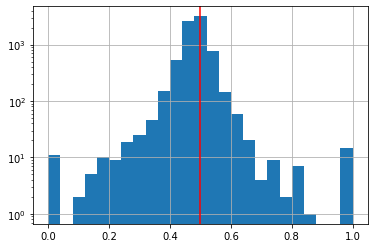

In [60]:
ax = join_students_info_outer_df['Female Enrollment'].hist(bins=25)
ax.set_yscale('log')
ax.axvline(.5,color='r')

In [75]:
join_students_info_outer_df['System Code'].value_counts()

Public              7421
Non-Public           720
Head Start           251
Facility Sch          45
--                    20
Detention Center       9
Name: System Code, dtype: int64

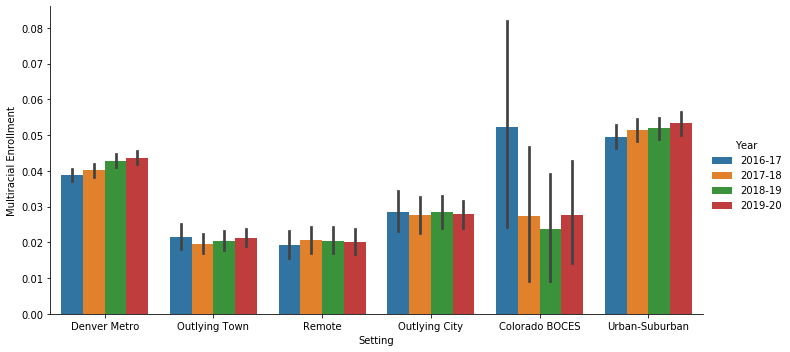

In [83]:
sb.catplot(data=join_students_info_outer_df,
           x='Setting',
           y='Multiracial Enrollment',
           hue='Year',
           dodge=.5,
           kind='bar',aspect=2)

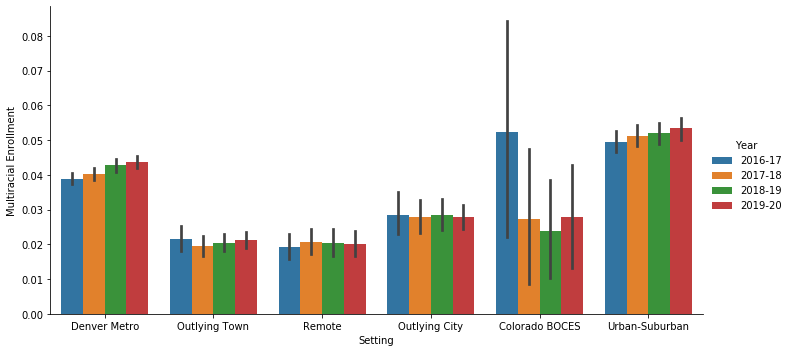

In [82]:
sb.catplot(data=join_students_info_inner_df,
           x='Setting',
           y='Multiracial Enrollment',
           hue='Year',
           dodge=.5,
           kind='bar',aspect=2)

## Appendix

It was a fair bit of work to turn the raw data into the data we used in class. You will not be evaluated on you knowledge of anything in this or any future appendix, but if you want to see how the sausage is made to improve your own game, I've included all the steps I took to clean up the data below. Note that this was ~4 hours of work, not something I just threw together in my spare time: it took time for me to get it right!

To make the files we used in the class exercise required some data cleanup of the raw files:
* **Information.** CDE's [SchoolView](https://www.cde.state.co.us/schoolview) publishes general information about "All Colorado Schools (XLS)"
* **Immunization.** CDPHE [Community Partner](https://www.dcphrapps.dphe.state.co.us/Reports/ReportList/Partners) for 2017-2020 and [2016-2017](https://www.cohealthdata.dphe.state.co.us/Data/Details/1) school-level data
* **Enrollments.** CDE's [Current](https://www.cde.state.co.us/cdereval/pupilcurrent) and [Archival](https://www.cde.state.co.us/cdereval/rvprioryearpmdata) Pupil Membership "School Level Data" for "Race/Ethnicity and Gender by Grade and School".


In [ ]:
import os

### General information

In [ ]:
info_df[['Elem Level','Middle Level','Senior Level','Charter']].replace({'N':False,'Y':True})

In [ ]:
info_df = pd.read_excel('./Schools/schools_information.xlsx',skiprows=[0,1,2],
                        dtype={'District Code':str,'Sch Code':str,'Low Grade':str,'High Grade':str})

info_df[['Elem Level','Middle Level','Senior Level','Charter?']] = info_df[['Elem Level','Middle Level','Senior Level','Charter?']].replace({'N':False,'Y':True})
info_df.rename(columns={'Charter?':'Charter'},inplace=True)
info_df['County Name'] = info_df['County Name'].str.title()
info_df['School Name'] = info_df['School Name'].str.title()

info_df.to_csv('cleaned_school_info.csv',encoding='utf8',index=False)

info_df.head()

In [ ]:
info_df['County Name'].value_counts()

In [ ]:
info_df['District Name'].value_counts()

In [ ]:
info_df['Setting'].value_counts()

In [ ]:
info_df['System Code'].value_counts()

In [ ]:
info_df['Charter'].value_counts()


### Immunization
The raw school immunizations data does not contain School or District Codes to make these joins easier.

#### 2016-2017 data

In [ ]:
# Read in file
imm_1617_df = pd.read_excel('./Schools/schools_immunization_2016-17.xlsx').dropna(subset=['Total Enrollment (Includes 6-12 Grade Enrollment)'])

# Identify "good" column names and skip columns that have "Unnamed: " in them
immunization_good_cols = [col for col in imm_1617_df.columns if 'Unnamed: ' not in col]

# Reshape the DataFrame to keep the columns in immunization_good_cols
imm_1617_df = imm_1617_df[immunization_good_cols]

# Clean up some of the values and columns
imm_1617_df.replace({'School Type':{'HIGH':'High'}},inplace=True)

imm_1617_df.rename(columns={'School District Label':'School District',
                                 'Total Enrollment (Includes 6-12 Grade Enrollment)':'Total Enrollment',
                                 '6-12 Grade Enrollment (Tdap Eligible)':'6-12 Grade Enrollment'}
                        ,inplace=True)

imm_1617_df['School Name'] = imm_1617_df['School Name'].str.upper()

# Extract — very imperfectly – the street address
imm_1617_df['Street Address'] = imm_1617_df['Address'].str.replace(',CO',', CO').str.extract(r'([^,]+), CO')
imm_1617_df['Zipcode'] = imm_1617_df['Address'].str.extract(r'CO (\d{5})')

# Clean up school name
imm_1617_df['School Name'] = imm_1617_df['School Name'].str.title()

# Rename primary column of interest
imm_1617_df.rename(columns={'Average Up to Date Rate':'2016-17 Vacciations'},inplace=True)

# Inspect
print("There are {0:,} rows of data.".format(len(imm_1617_df)))
imm_1617_df.head()

#### 2017-2020 data

In [ ]:
immunization_df = pd.read_csv('./Schools/schools_alldata.csv',dtype={"Site ID":str,'Zip':str},thousands=',')
immunization_df.columns = [i.strip() for i in immunization_df.columns]
immunization_df.head()

What's the shape of the data? (rows, columns)

In [ ]:
immunization_df.shape

In [ ]:
# This is troubling that these are objects instead of ints
immunization_df['Total Students'].head()

In [ ]:
# It turns out there are commas and some other mischevious values snuck in there
# Replace and cast to floats
immunization_df['Total Students'] = immunization_df['Total Students'].str.replace(',','').str.replace('<10','10').astype(float)

In [ ]:
# Subset to the "Fully Immunized Percent" in "Measure Names"
fully_immunized_boolean = immunization_df['Measure Names'] == 'Fully Immunized Percent'

# Subset to "School" in "Survey Type" to exclude K and Pre-K surveys
school_survey_type_boolean = immunization_df['Survey Type'] == 'School'

# Boolean index
fully_immunized_df = immunization_df[fully_immunized_boolean & school_survey_type_boolean].copy()

# Inspect
fully_immunized_df.head()

In [ ]:
# Pivot to unmelt
site_year_vaccine_pct_df = pd.pivot_table(data = fully_immunized_df,
                                          index = 'Site Name',
                                          columns = 'Year',
                                          values = 'Measure Values',
                                          aggfunc = 'min'
                                         )

# Clean index
school_vaccination_df = site_year_vaccine_pct_df.reset_index()

# Rename columns
school_vaccination_df.columns = ['School Name','2017-18 Vaccinations','2018-19 Vaccinations','2019-20 Vaccinations']
school_vaccination_df.columns.name = None

# Try to clean school names
school_vaccination_df['School Name'] = school_vaccination_df['School Name'].str.title()

# Join in 2016-17 data
_right = imm_1617_df[['School Name','2016-17 Vacciations']].copy()
school_vaccination_df = pd.merge(left = school_vaccination_df,
                                 right = _right,
                                 on = 'School Name',
                                 how = 'outer')

# Re-order columns
_new_col_order = ['School Name','2016-17 Vacciations','2017-18 Vaccinations','2018-19 Vaccinations','2019-20 Vaccinations']
school_vaccination_df = school_vaccination_df[_new_col_order]

# Save file
school_vaccination_df.to_csv('cleaned_school_vaccination.csv',encoding='utf8',index=False)

# Inspect
print(school_vaccination_df.shape)
school_vaccination_df.head(15)

In [ ]:
# Re-order columns
school_information_df = fully_immunized_df[['Site Name','Site ID','Address','City','County','School District','School Type','Type of Facility','Zip']].drop_duplicates(subset=['Site ID']).reset_index(drop=True)

# Try to clean school names
school_information_df['Site Name'] = school_information_df['Site Name'].str.title()

# Save to file
school_information_df.to_csv('cleaned_school_information.csv',encoding='utf8',index=False)

# Inspect
print(school_information_df.shape)
school_information_df.head()

### School enrollments

In [ ]:
enrollment_1617_df = pd.read_excel('./Schools/2016-17-Membership-Race-Gender-byGradeSchool.xlsx',
                        skiprows=[0,1,3],
                        dtype={'School Code':str,'Org. Code':str})
enrollment_1617_df.head()

In [ ]:
# Read in the files
membership_files = sorted([f for f in os.listdir('./Schools/') if 'Membership' in f])

# Empty container for concatenation
annual_all_grades_d = {}

for f in membership_files:
    _df = pd.read_excel('./Schools/' + f,
                        skiprows=[0,1,3],
                        dtype={'School Code':str,'Org. Code':str})
    
    # Yay inconsistent values across files
    _df['Grade Level'].replace({'ALL GRADES TOTAL':'ALL GRADE LEVELS'},inplace=True)
    
    # Make Boolean indexes to identify the rows to keep
    # Exclude rows containing "Not a school"
    _true_schools = _df['School Name'] != 'Not a school'

    # Include rows for "ALL GRADES TOTAL"
    _all_grades = _df['Grade Level'] == 'ALL GRADE LEVELS'

    _all_grades_df = _df[_true_schools & _all_grades].copy()
    
    _all_grades_df['School Name'] = _all_grades_df['School Name'].str.title()

    _all_grades_df['Native Enrollment'] = (_all_grades_df['American Indian or Alaskan Native Female'] + _all_grades_df['American Indian or Alaskan Native Male'])/_all_grades_df['PK-12 Total']
    _all_grades_df['Asian Enrollment'] = (_all_grades_df['Asian Female'] + _all_grades_df['Asian Male'])/_all_grades_df['PK-12 Total']
    _all_grades_df['Black Enrollment'] = (_all_grades_df['Black or African American Female'] + _all_grades_df['Black or African American Male'])/_all_grades_df['PK-12 Total']
    _all_grades_df['Hispanic Enrollment'] = (_all_grades_df['Hispanic or Latino Female'] + _all_grades_df['Hispanic or Latino Male'])/_all_grades_df['PK-12 Total']
    _all_grades_df['White Enrollment'] = (_all_grades_df['White Female'] + _all_grades_df['White Male'])/_all_grades_df['PK-12 Total']
    _all_grades_df['Islander Enrollment'] = (_all_grades_df['Native Hawaiian or Other Pacific Islander Female'] + _all_grades_df['Native Hawaiian or Other Pacific Islander Male'])/_all_grades_df['PK-12 Total']
    _all_grades_df['Multiracial Enrollment'] = (_all_grades_df['Two or More Races Female'] + _all_grades_df['Two or More Races Female'])/_all_grades_df['PK-12 Total']
    _female_cols = [col for col in _all_grades_df.columns if ' Female' in col]
    _all_grades_df['Female Enrollment'] = _all_grades_df[_female_cols].sum(axis=1)/_all_grades_df['PK-12 Total']
    
    _info_cols = _all_grades_df.columns[:4].tolist()
    _enrollment_cols = _all_grades_df.columns[-8:].tolist()
    
    _cleaned_df = _all_grades_df[_info_cols + _enrollment_cols + ['PK-12 Total']].reset_index(drop=True)
    _year = f[:7]
    print(_year,len(_cleaned_df))
    annual_all_grades_d[_year] = _cleaned_df

In [ ]:
# Concatenate together
enrollment_df = pd.concat(annual_all_grades_d,names=['Year','Index'])

# Clean up index
enrollment_df = enrollment_df.reset_index(0).reset_index(drop=True)

# Save to disk
enrollment_df.to_csv('cleaned_school_enrollments.csv',encoding='utf8',index=False)

# Inspect
print(enrollment_df.shape)
enrollment_df.head()